sample: 100%|██████████| 25000/25000 [07:26<00:00, 56.00it/s, 35 steps of size 5.61e-02. acc. prob=0.75]   



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha0      0.94      0.35      0.89      0.43      1.48   1300.52      1.00
      beta_1     11.19      8.53      8.82      1.61     22.59   2695.35      1.00
      beta_2      1.54      0.24      1.56      1.19      1.95   1812.68      1.00
      beta_3      0.76      0.10      0.74      0.62      0.92   1657.55      1.00
      beta_4      0.77      0.07      0.76      0.66      0.88   1636.85      1.00
      beta_5      0.71      0.04      0.71      0.65      0.78   3063.08      1.00
      beta_6      0.68      0.03      0.68      0.62      0.74   5255.20      1.00
      beta_7      0.67      0.03      0.67      0.61      0.72   3520.95      1.00
      beta_8      0.67      0.03      0.67      0.62      0.71   4066.15      1.00
beta_tilt[0]      0.46      0.12      0.47      0.25      0.66   2418.10      1.00
beta_tilt[1]      0.22      0.12      0.19      0.04      0.41   1386.56      1.00
bet

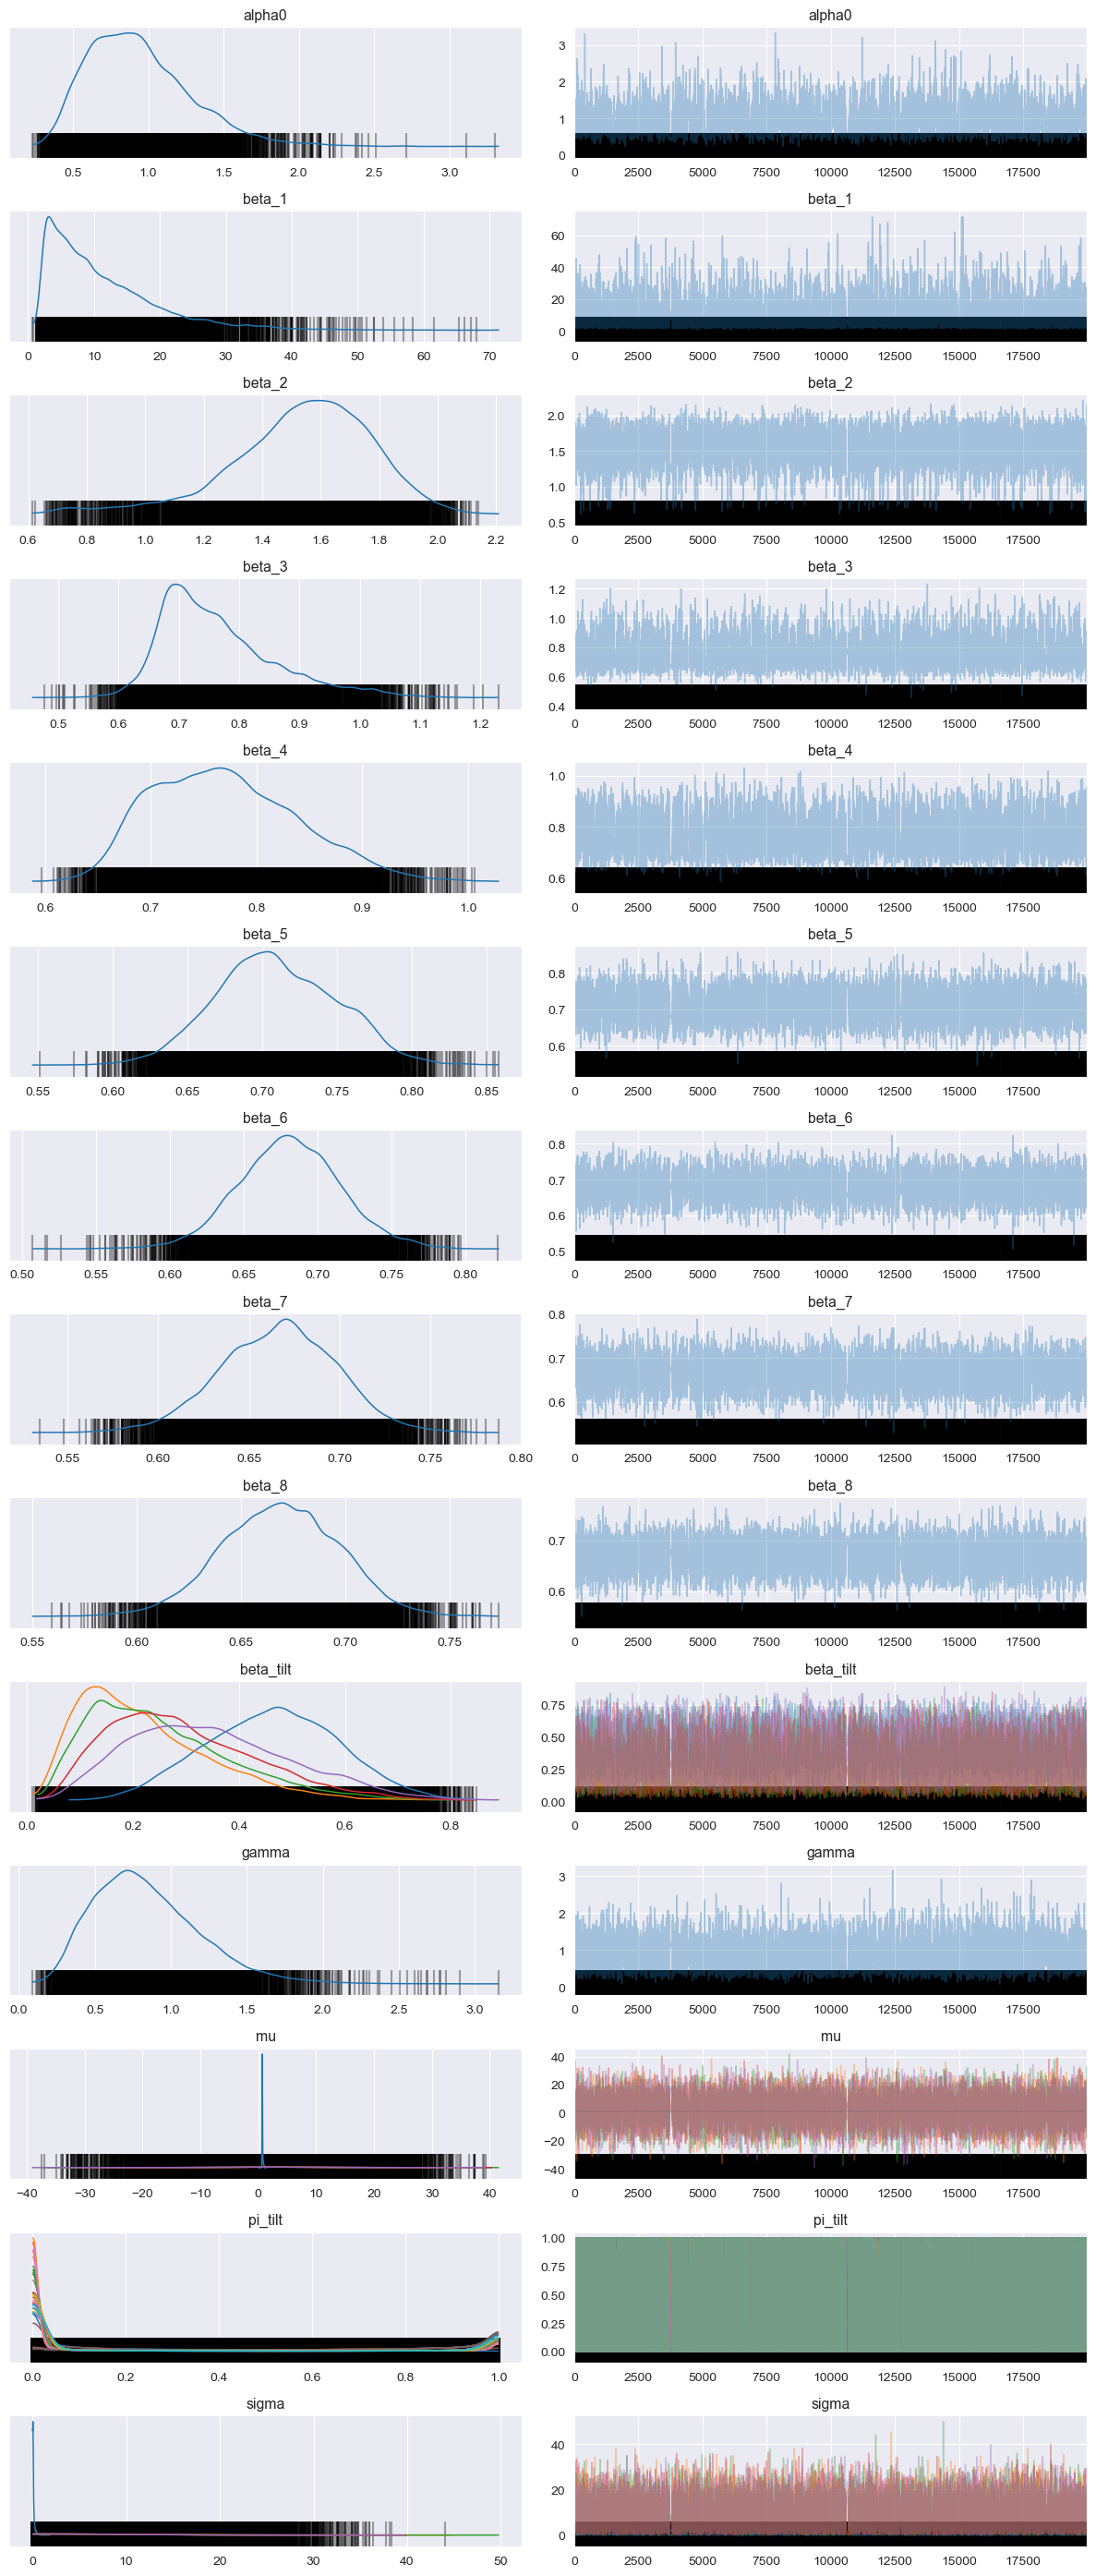

In [2]:
import jax.numpy as jnp
import jax.random as random
import numpy as np
import pandas as pd
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az
import matplotlib.pyplot as plt

data = pd.read_csv("profileLikelihoods_NCs_long.csv")


N_sources = 8

source_outcome_data = {}
for s in range(1, N_sources + 1):
    df = data[data["source"] == s][["point", "value", "outcome"]].astype(float)
    outcome_list = []

    for outcome in sorted(df["outcome"].unique()):
        outcome_array = jnp.array(df[df["outcome"] == outcome].values)
        outcome_list.append(outcome_array)
    source_outcome_data[s] = outcome_list


num_outcomes_dict = {s: len(source_outcome_data[s]) for s in range(1, N_sources + 1)}


def interpolate(x0, y0, x):
    """Linear interpolation using JAX's jnp.interp."""
    return jnp.interp(x, x0, y0)

def custom_loglike(beta, outcome_data_list):
    """
    Computes the total log-likelihood for a given beta value.
    outcome_data_list is a list of preprocessed arrays, one for each outcome.
    """
    total_ll = 0.0
    for outcome_data in outcome_data_list:
        x_vals = outcome_data[:, 0]       # grid points
        loglike_vals = outcome_data[:, 1]   # corresponding log-likelihood values
        ll = jnp.interp(beta, x_vals, loglike_vals)
        total_ll += ll
    return total_ll

def stick_breaking(beta):
    """Perform stick-breaking transformation."""
    portion_remaining = jnp.concatenate([jnp.array([1.0]), jnp.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

def reparameterize(pi):
    """Normalize to sum to one."""
    return pi / jnp.sum(pi)

# -------------------------
# NumPyro Model Definition
# -------------------------
def HDP_model(source_outcome_data, num_outcomes_dict, N_sources, k, data_point_mean):
    # Hyperpriors
    gamma = numpyro.sample("gamma", dist.Gamma(1.0, 5.0))
    alpha0 = numpyro.sample("alpha0", dist.Gamma(1.0, 5.0))
    
    # Global stick-breaking for mixture weights.
    beta_tilt = numpyro.sample("beta_tilt", dist.Beta(1.0, gamma).expand([k]))
    beta = stick_breaking(beta_tilt)
    
    beta_cumsum = jnp.cumsum(beta)
    pi_tilt = numpyro.sample("pi_tilt",
                             dist.Beta(alpha0 * beta, alpha0 * (1 - beta_cumsum))
                             .expand([N_sources, k]))
    
    # Compute source-specific mixture weights
    pi_norms = []
    for s in range(N_sources):
        pi_source = stick_breaking(pi_tilt[s])
        pi_norm = reparameterize(pi_source)
        pi_norms.append(pi_norm)
    
    # Mixture component parameters (μ not forced to be ordered here)
    mu = numpyro.sample("mu", dist.Normal(data_point_mean, 10.0).expand([k]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(10.0).expand([k]))
    
    # Likelihood for each source
    for s in range(1, N_sources + 1):
        # Define a mixture model for source s using the precomputed weights.
        mixture_dist = dist.MixtureSameFamily(
            dist.Categorical(probs=pi_norms[s - 1]),
            dist.Normal(loc=mu, scale=sigma)
        )
        # Sample beta for source s
        beta_s = numpyro.sample(f"beta_{s}", mixture_dist)
        
        # Use the pre-processed outcome-specific arrays for source s.
        outcome_data_list = source_outcome_data[s]
        # Define clipping bounds based on the grid points (using first and last outcome arrays).
        grid_min = jnp.min(outcome_data_list[0][:, 0])
        grid_max = jnp.max(outcome_data_list[-1][:, 0])
        beta_clipped = jnp.clip(beta_s, grid_min, grid_max)
        
        # Add the custom log-likelihood as an extra factor.
        # This factor effectively incorporates your posterior likelihood.
        ll = custom_loglike(beta_clipped, outcome_data_list)
        numpyro.factor(f"loglike_{s}", ll)

# -------------------------
# Inference
# -------------------------
# Create a PRNG key
rng_key = random.PRNGKey(0)
data_point_mean = data["point"].mean()
k = 5  # Number of mixture components

# Set up and run MCMC using the NUTS sampler.
nuts_kernel = NUTS(HDP_model)
mcmc = MCMC(nuts_kernel, num_warmup=5000, num_samples=20000)
mcmc.run(rng_key,
         source_outcome_data=source_outcome_data,
         num_outcomes_dict=num_outcomes_dict,
         N_sources=N_sources,
         k=k,
         data_point_mean=data_point_mean)
mcmc.print_summary()

idata = az.from_numpyro(mcmc)

# Plot the trace plots for all parameters.
az.plot_trace(idata)
plt.tight_layout()
plt.show()


In [ ]:
import jax
import jax.numpy as jnp
import jax.random as random
import numpy as np
import pandas as pd
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

data = pd.read_csv("profileLikelihoods_NCs_long.csv")

N_sources = 8

source_outcome_data = {}
for s in range(1, N_sources + 1):
    df = data[data["source"] == s][["point", "value", "outcome"]].astype(float)
    outcome_list = []
    for outcome in sorted(df["outcome"].unique()):
        outcome_array = jnp.array(df[df["outcome"] == outcome].values)
        outcome_list.append(outcome_array)
    source_outcome_data[s] = outcome_list

num_outcomes_dict = {s: len(source_outcome_data[s]) for s in range(1, N_sources + 1)}

def interpolate(x0, y0, x):
    """Linear interpolation using JAX's jnp.interp."""
    return jnp.interp(x, x0, y0)

def custom_loglike(beta, outcome_data_list):
    """
    Computes the total log-likelihood for a given beta value.
    outcome_data_list is a list of preprocessed arrays, one for each outcome.
    """
    total_ll = 0.0
    for outcome_data in outcome_data_list:
        # Extract grid points and corresponding log-likelihood values.
        x_vals = outcome_data[:, 0]       # grid points
        loglike_vals = outcome_data[:, 1]   # corresponding log-likelihood values
        # Interpolate log-likelihood at the given beta value.
        ll = jnp.interp(beta, x_vals, loglike_vals)
        total_ll += ll
    return total_ll

def stick_breaking(beta):
    """Perform stick-breaking transformation."""
    portion_remaining = jnp.concatenate([jnp.array([1.0]), jnp.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

def reparameterize(pi):
    """Normalize to sum to one."""
    return pi / jnp.sum(pi)

# -------------------------
# NumPyro Model Definition
# -------------------------
def HDP_model(source_outcome_data, num_outcomes_dict, N_sources, k, data_point_mean):
    # Hyperpriors
    pi_global = numpyro.sample("pi_global", dist.Dirichlet(jnp.ones(k)))
    
    # Mixture component parameters (μ not forced to be ordered here)
    mu = numpyro.sample("mu", dist.Normal(data_point_mean, 10.0).expand([k]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(10.0).expand([k]))
    
    # Likelihood for each source using the same global mixture proportions.
    for s in range(1, N_sources + 1):
        mixture_dist = dist.MixtureSameFamily(
            dist.Categorical(probs=pi_global),
            dist.Normal(loc=mu, scale=sigma)
        )
        # Sample beta for source s from the common mixture model.
        beta_s = numpyro.sample(f"beta_{s}", mixture_dist)
        
        # Use the pre-processed outcome-specific arrays for source s.
        outcome_data_list = source_outcome_data[s]
        # Define clipping bounds based on the grid points (using first and last outcome arrays).
        grid_min = jnp.min(outcome_data_list[0][:, 0])
        grid_max = jnp.max(outcome_data_list[-1][:, 0])
        beta_clipped = jnp.clip(beta_s, grid_min, grid_max)
        
        # Add the custom log-likelihood as an extra factor.
        ll = custom_loglike(beta_clipped, outcome_data_list)
        numpyro.factor(f"loglike_{s}", ll)

# -------------------------
# Inference
# -------------------------
rng_key = random.PRNGKey(0)
data_point_mean = data["point"].mean()
k = 5  # Number of mixture components

# Set up and run MCMC using the NUTS sampler.
nuts_kernel = NUTS(HDP_model)
mcmc2 = MCMC(nuts_kernel, num_warmup=5000, num_samples=20000)
mcmc2.run(rng_key,
         source_outcome_data=source_outcome_data,
         num_outcomes_dict=num_outcomes_dict,
         N_sources=N_sources,
         k=k,
         data_point_mean=data_point_mean)
mcmc2.print_summary()

idata2 = az.from_numpyro(mcmc)

# Plot the trace plots for all parameters.
az.plot_trace(idata2)
plt.tight_layout()
plt.show()


warmup:  14%|█▎        | 3392/25000 [07:33<1:24:22,  4.27it/s, 1023 steps of size 2.56e-03. acc. prob=0.79]

# Custom Likelihood For Mean

This notebook demonstrates a simple example to test whether a customized likelihood works. In this example, we:

1. **Generate synthetic data:**  
   We simulate 50 samples from a normal distribution, i.e., from \$ N(5, 1) \$. These data points represent our observed data.

2. **Create a grid for \$\mu\$ and compute its log-likelihood:**  
   We create a grid of candidate \$\mu\$ values (from 0 to 10) and, for each candidate, compute the total log-likelihood of the data (assuming known standard deviation \$\sigma=1\$).  
   The log-likelihood at each grid point is calculated as  
   $$
   \text{loglike}(\mu) = \sum_{i=1}^{n} \log \left( \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{(y_i - \mu)^2}{2}\right) \right)
   $$
   This grid serves as our precomputed likelihood surface.

3. **Define a custom likelihood function:**  
   The function `custom_loglike` uses linear interpolation (via JAX's `jnp.interp`) to "look up" the log-likelihood for any given value of \$\mu\$, based on our precomputed grid.

4. **Define the NumPyro model:**  
   - We place a prior on \$\mu\$ (a wide normal prior, e.g., \$\mu \sim N(0, 10)\$).
   - We clip \$\mu\$ to ensure it falls within the grid range.
   - We incorporate the custom log-likelihood into the model using `numpyro.factor`, which adds this log probability to the joint log density.

5. **Run inference using MCMC:**  
   Finally, we run MCMC (with the NUTS sampler) to sample from the posterior of \$\mu\$. If the model works correctly, the posterior should concentrate around the true value of 5.


In [1]:
import jax.numpy as jnp
import jax.random as random
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# -------------------------
# 1. Generate Synthetic Data
# -------------------------
# For reproducibility
np.random.seed(42)
# Generate 50 samples from N(5,1)
y = np.random.normal(loc=5, scale=1, size=50)

# -------------------------
# 2. Create a Grid for μ and Compute its Log-Likelihood
# -------------------------
# Create a grid of μ values (from 0 to 10)
grid_mu = np.linspace(0, 10, 100)
# For each grid point, compute the total log likelihood of the data (assuming known sigma=1)
from scipy.stats import norm
loglike_grid = [np.sum(norm.logpdf(y, loc=mu, scale=1)) for mu in grid_mu]

# Build a data array with columns: [mu (grid point), log-likelihood, outcome]
# Since we only have one outcome here, set outcome = 1 for all rows.
data_array = np.column_stack([grid_mu, loglike_grid, np.ones_like(grid_mu)])

# -------------------------
# 3. Define Helper Functions for the Custom Likelihood
# -------------------------
def interpolate(x0, y0, x):
    """
    Linear interpolation using jnp.interp.
    x0: grid points (assumed sorted)
    y0: corresponding log-likelihood values
    x: value at which to evaluate the interpolation
    """
    return jnp.interp(x, x0, y0)

def custom_loglike(mu, source_data):
    """
    Custom log-likelihood function.
    Here, source_data is expected to be a 2D array with columns [point, value, outcome].
    Since we have only one outcome, we simply use all rows.
    """
    # Extract the grid (points) and corresponding log-likelihood values.
    x_vals = source_data[:, 0]
    loglike_vals = source_data[:, 1]
    # Interpolate to obtain the log-likelihood for the given mu.
    return interpolate(x_vals, loglike_vals, mu)

# -------------------------
# 4. Define the NumPyro Model
# -------------------------
def model(source_data):
    # Prior for μ: a wide Normal prior (centered at 0)
    mu = numpyro.sample("mu", dist.Normal(0, 10))
    
    # Optionally clip μ to be within the grid range
    grid_min = jnp.min(source_data[:, 0])
    grid_max = jnp.max(source_data[:, 0])
    mu_clipped = jnp.clip(mu, grid_min, grid_max)
    
    # Compute the custom log-likelihood (interpolated from the grid)
    ll = custom_loglike(mu_clipped, source_data)
    # Add the custom log-likelihood to the model's joint log probability.
    numpyro.factor("custom_ll", ll)

# -------------------------
# 5. Run Inference with MCMC
# -------------------------
rng_key = random.PRNGKey(0)
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key, source_data=jnp.array(data_array))
mcmc.print_summary()

# Optionally, extract the posterior samples for μ:
posterior_samples = mcmc.get_samples()["mu"]
print("Posterior mean for mu:", np.mean(posterior_samples))


sample: 100%|██████████| 3000/3000 [00:01<00:00, 2816.62it/s, 3 steps of size 9.26e-01. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.77      0.14      4.78      4.53      5.00    765.25      1.00

Number of divergences: 0
Posterior mean for mu: 4.774934




# Hierarchical Mixture Model with Customized Likelihood

This notebook demonstrates a hierarchical mixture model using NumPyro that incorporates a custom likelihood function. The model is based on three fixed Gaussian components:

- **Component 1:** $N(0,1)$  
- **Component 2:** $N(4,1)$  
- **Component 3:** $N(9,1)$  

For each of multiple groups, the model assumes each group has its own mixing weights for these components, and these weights are modeled hierarchically using a Dirichlet distribution with a hyperprior on its concentration parameter.

## Code Breakdown

### 1. Synthetic Data Generation

- **Purpose:**  
  Generate synthetic data for three groups, with each group containing 50 observations.
  
- **Process:**  
  - For each group, the “true” mixing weights are defined (these differ across groups).  
  - For every observation in a group, a component is chosen based on these mixing weights, and a sample is drawn from the corresponding normal distribution.
  
- **Output:**  
  The generated data for each group is stored in a list called `data_by_group`.

### 2. Hierarchical Mixture Model Definition

- **Hyperparameter $\alpha_0$:**  
  - Sampled from a Gamma distribution.  
  - Acts as the concentration parameter for the Dirichlet distribution that models the group-specific mixing weights.

- **Group-Specific Mixing Weights:**  
  - For each group, mixing weights ($\\pi$) are sampled from a Dirichlet distribution parameterized by $\\alpha_0$ and a base measure (uniform in this case).

- **Customized Likelihood:**  
  - Instead of using a standard likelihood, the code defines a custom log-likelihood function for each group's data.
  - For each observation $y$ in a group, the log probability is computed for each of the three components as:
    - $\log(\\pi_1) + \log \\; N(y;0,1)$
    - $\log(\\pi_2) + \log \\; N(y;4,1)$
    - $\log(\\pi_3) + \log \\; N(y;9,1)$
  - These values are combined using the log-sum-exp trick to compute the overall log likelihood for that observation.
  - The total log-likelihood for all observations in a group is then added to the model’s joint log probability using `numpyro.factor`.

### 3. Inference

- **MCMC Sampling:**  
  - The model uses the NUTS sampler to perform MCMC.
  - The MCMC is configured with 1,000 warmup steps and 2,000 samples.
  
- **Outcome:**  
  Posterior samples are drawn for the hyperparameter $\\alpha_0$ and the group-specific mixing weights $\\pi$.

### 4. Posterior Analysis

- **Post-Processing:**  
  - After sampling, the code extracts the posterior samples for each group's mixing weights.
  - It computes and prints the posterior mean for these weights, allowing a comparison with the true mixing weights used for data generation.

## Summary

- **Model Purpose:**  
  Build a hierarchical Bayesian model for data from multiple groups, each modeled as a mixture of three fixed normal distributions.

- **Customized Likelihood:**  
  Instead of a standard likelihood, a custom likelihood is computed by manually combining the log probabilities from each mixture component. This likelihood is added as a factor in the model to contribute to the posterior.

- **Inference:**  
  MCMC via NUTS is used to sample from the posterior, and the resulting samples are used to analyze the inferred group-specific mixing weights.

You can run the code cells in this notebook to see how the model fits the synthetic data and how well it recovers the true mixing weights.

---

In [2]:
import jax.numpy as jnp
import jax
import jax.random as random
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.scipy.special

# -------------------------
# 1. Generate Synthetic Data
# -------------------------
# For reproducibility
np.random.seed(0)
n_groups = 3
n_samples = 50

# True mixing weights for each group (they differ across groups)
true_mixing_weights = [
    np.array([0.7, 0.2, 0.1]),
    np.array([0.2, 0.5, 0.3]),
    np.array([0.1, 0.2, 0.7])
]

# Fixed component parameters: N(0,1), N(4,1), N(9,1)
components = [(0, 1), (4, 1), (9, 1)]
data_by_group = []
for g in range(n_groups):
    group_data = []
    for i in range(n_samples):
        comp = np.random.choice(3, p=true_mixing_weights[g])
        mu_true, sigma_true = components[comp]
        y = np.random.normal(loc=mu_true, scale=sigma_true)
        group_data.append(y)
    data_by_group.append(np.array(group_data))

# -------------------------
# 2. Define the Hierarchical Mixture Model with Customized Likelihood
# -------------------------
def hierarchical_mixture_model(data_by_group):
    # Hyperprior for the concentration parameter of the Dirichlet.
    alpha0 = numpyro.sample("alpha0", dist.Gamma(2.0, 1.0))
    # A base measure (here uniform) for the Dirichlet distribution
    base = jnp.ones(3)
    
    # For each group, sample group-specific mixing weights.
    for g, data in enumerate(data_by_group):
        pi = numpyro.sample(f"pi_{g}", dist.Dirichlet(alpha0 * base))
        
        # Define a custom log-likelihood for an individual observation y.
        def mixture_loglik(y):
            # For each component compute:
            # log( pi_i ) + log( Normal(y; mu_i, sigma_i) )
            log_comp1 = jnp.log(pi[0]) + dist.Normal(0, 1).log_prob(y)
            log_comp2 = jnp.log(pi[1]) + dist.Normal(4, 1).log_prob(y)
            log_comp3 = jnp.log(pi[2]) + dist.Normal(9, 1).log_prob(y)
            # Combine the component contributions using logsumexp.
            return jax.scipy.special.logsumexp(jnp.array([log_comp1, log_comp2, log_comp3]))
        
        # Evaluate the custom likelihood for all observations in the group.
        group_loglik = jnp.sum(jax.vmap(mixture_loglik)(data))
        # Add the custom log-likelihood factor to the joint log density.
        numpyro.factor(f"loglik_group_{g}", group_loglik)

# -------------------------
# 3. Run Inference via MCMC
# -------------------------
rng_key = random.PRNGKey(0)
nuts_kernel = NUTS(hierarchical_mixture_model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key, data_by_group=data_by_group)
mcmc.print_summary()

# -------------------------
# 4. Posterior Analysis
# -------------------------
# Extract and print the posterior means for the mixing weights for each group.
posterior = mcmc.get_samples()
for g in range(n_groups):
    pi_samples = posterior[f"pi_{g}"]
    print(f"Group {g} mixing weights posterior mean:", jnp.mean(pi_samples, axis=0))


sample: 100%|██████████| 3000/3000 [00:02<00:00, 1291.43it/s, 7 steps of size 6.92e-01. acc. prob=0.89]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    alpha0      1.76      0.81      1.61      0.57      2.97   1942.62      1.00
   pi_0[0]      0.71      0.06      0.72      0.61      0.81   2432.15      1.00
   pi_0[1]      0.16      0.05      0.16      0.08      0.25   2741.87      1.00
   pi_0[2]      0.12      0.05      0.12      0.05      0.19   2544.73      1.00
   pi_1[0]      0.14      0.05      0.14      0.07      0.21   2466.89      1.00
   pi_1[1]      0.57      0.07      0.57      0.45      0.67   2646.25      1.00
   pi_1[2]      0.29      0.06      0.28      0.18      0.38   2859.15      1.00
   pi_2[0]      0.14      0.05      0.14      0.06      0.22   3214.34      1.00
   pi_2[1]      0.29      0.06      0.28      0.18      0.38   3428.17      1.00
   pi_2[2]      0.57      0.07      0.58      0.46      0.68   3667.40      1.00

Number of divergences: 0
Group 0 mixing weights posterior mean: [0.71499145 0.1613238  0.12368481]
Group 1 